# Clust

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Input

In [2]:
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import normalize

def import_data(file_name: str) -> (np.array, np.array):
    data = np.genfromtxt(file_name, dtype=None, delimiter=',', names=True)
    xs = np.array([x.tolist()[1:] for x in data])
    ys = np.array([x[0] - 1 for x in data])
    return xs, ys

def onehot(ys):
    so_hot = np.empty((0, 3), int)
    for y in ys:
      arr = np.zeros((1, 3))
      arr[0][y] = 1
      so_hot = np.append(so_hot, arr, axis=0)
    return so_hot

xs_original, ys_original = import_data("/content/drive/MyDrive/Colab Notebooks/resources/wine.csv")

xs = preprocessing.MinMaxScaler().fit_transform(xs_original)
ys = onehot(ys_original)

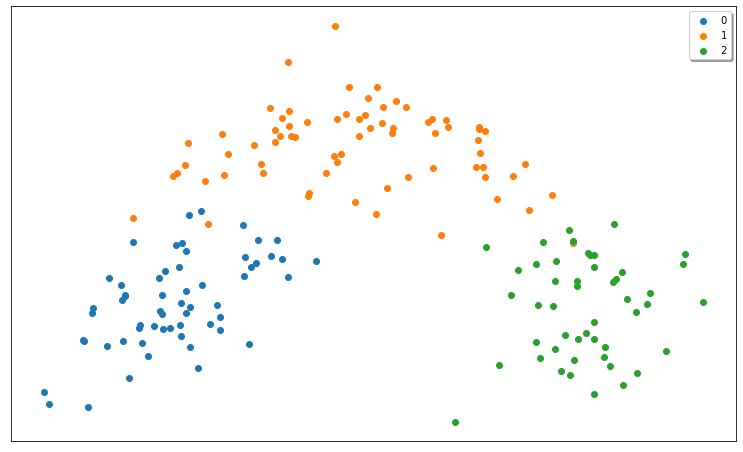

In [3]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from itertools import groupby

def dependency_plot(xlabel, ylabel, results):
    plt.figure(figsize = (13,8))
    plt.plot([x for x, _ in results], [y for _, y in results])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # plt.set_ybound(-1.0, 1.0)
    # plt.set_xbound(results[0][1], results[-1][1])
    plt.grid(True)
    plt.show()

def pca_plot(xs: np.array, ys: np.array):
    pca = PCA(n_components=2).fit_transform(xs)
    pcadata = np.hstack((pca, np.array([[y] for y in ys])))
    plt.figure(figsize = (13,8))

    for x, current_ys in groupby(sorted(pcadata, key=lambda x: int(x[2])), lambda x: int(x[2])):
        current = np.array(list(current_ys))
        plt.scatter(current[:, 0], current[:, 1], cmap=plt.cm.coolwarm, label=int(current[0][-1]))

    plt.legend(loc="best", fancybox=True, shadow=True)
    plt.xticks(())
    plt.yticks(())
    plt.show()
  
pca_plot(xs, ys_original)

In [4]:
from random import random
from math import sqrt
from statistics import mean

UPPER_BOUND = 10000

EPSILON = 1e-8

def distance(a: np.array, b: np.array):
    return sqrt(sum((i - j) ** 2 for (i, j) in zip(a, b)))

def k_means(xs: np.array, k: int) -> np.array:

    centres = np.array([[random() for _ in range(len(xs[0]))] for _ in range(k)])

    for _ in range(UPPER_BOUND):
        clusters = []
        for x in xs:
            distances = [distance(x, cl) for cl in centres]
            cluster = distances.index(min(distances))
            clusters.append(cluster)

        clusters_xs = [[xs[i] for i in range(len(xs)) if clusters[i] == cl] for cl in range(k)]
        new_centres = np.array([
              [mean(x[i] for x in cl) for i in range(len(xs[0]))]
              if len(cl) > 0 else [0] * len(xs[0]) 
              for cl in clusters_xs
        ])

        difference = np.max(np.apply_along_axis(lambda diff: np.linalg.norm(diff), 1, centres - new_centres))

        if difference <= EPSILON:
            break

        centres = new_centres

    return np.array(clusters)

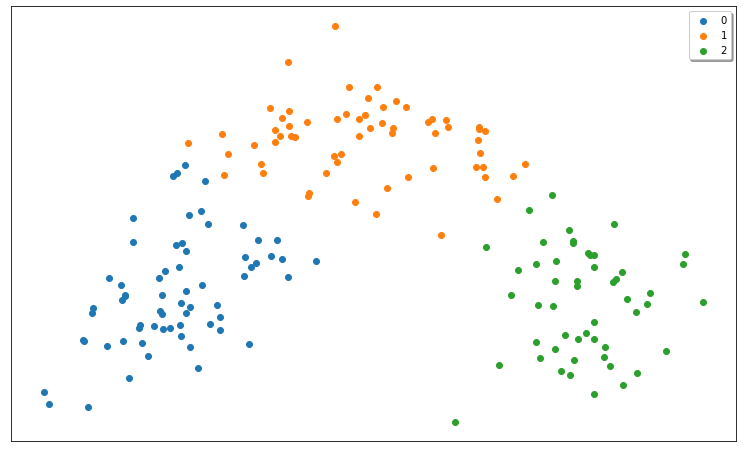

In [5]:
pca_plot(xs, k_means(xs, 3))

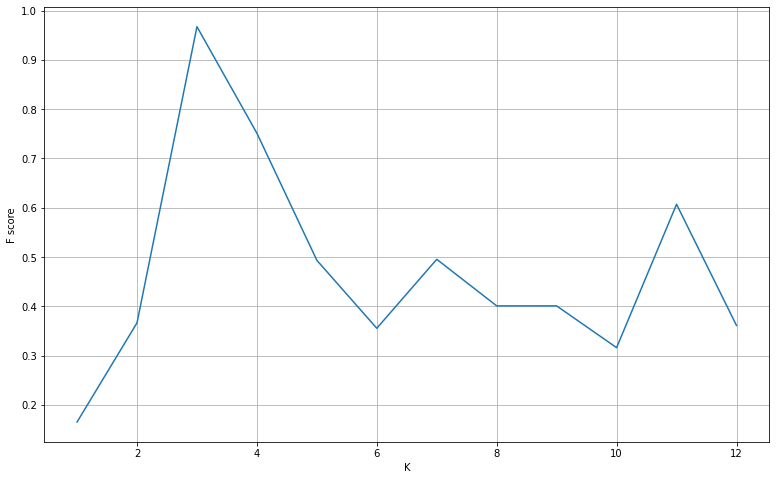

In [6]:
from sklearn.metrics import f1_score, confusion_matrix

def patch(expected: np.array, predicted: np.array) -> np.array:
    new_classes = {}

    values = set(expected)

    for i in values:
        classes_distribution = [
            len([x for e, x in zip(expected, predicted) if i == e and x == j])
            if j not in new_classes.values() else -1
            for j in values
        ]
        new_classes[i] = classes_distribution.index(max(classes_distribution))

    return np.array([new_classes[x] for x in predicted])

def f_score(expected: np.array, predicted: np.array) -> np.array:

    def confusion_matrix(expected: np.array, predicted: np.array) -> np.array:
        size = max(max(expected), max(predicted)) + 1
        confusion_matrix = np.zeros((size, size))

        for i in range(len(expected)):
            predicted_class = predicted[i]
            actual_class = expected[i]
            confusion_matrix[predicted_class if (predicted[i] == expected[i]) else actual_class][predicted_class] += 1
        return confusion_matrix

    def harmonic_mean(a: float, b: float) -> float:
        return 0 if a + b == 0 else 2 * a * b / (a + b)

    elements = confusion_matrix(expected, predicted)

    size = len(elements)

    row = [sum(i) for i in elements]
    column = [sum(map(lambda x: x[i], elements)) for i in range(size)]
    full = sum(row)

    precision = 0
    recall = 0

    for i in range(size):
        local_precision = 0 if row[i] == 0 else elements[i][i] / row[i]
        local_recall = 0 if column[i] == 0 else elements[i][i] / column[i]
        weight = row[i]

        precision += local_precision * weight
        recall += local_recall * weight

    return harmonic_mean(precision, recall) / full

ATTEMPTS = 10
LIMIT = 13
dependency_plot('K', 'F score', [(k, max(f_score(ys_original, k_means(xs, k)) for _ in range(ATTEMPTS))) for k in range(1, LIMIT)])

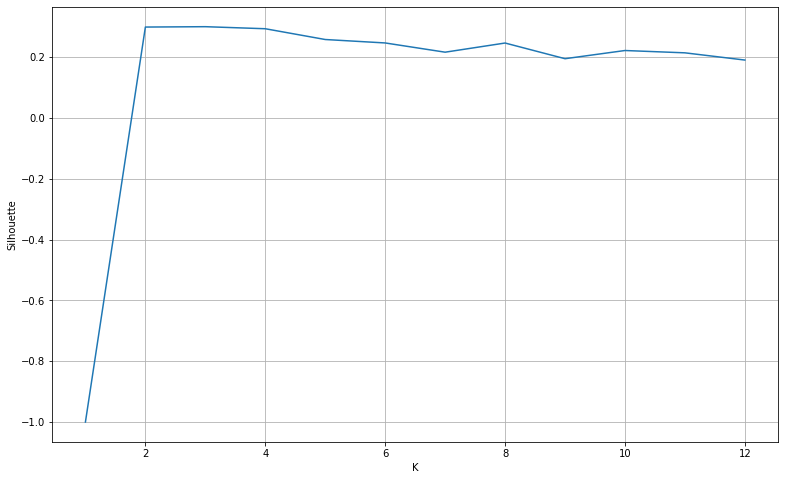

In [7]:
def silhouette(xs: np.array, ys: np.array) -> float:
    def cluster_distance(i: int, c: int) -> float:
        cluster = [distance(xs[i], xs[j]) for j in range(len(xs)) if ys[j] == c and j != i]
        return sum(cluster) / len(cluster) if len(cluster) != 0 else 0

    value = 0.

    for c in set(ys):
        for i in range(len(xs)):
            if ys[i] != c:
                continue

            x = xs[i]

            a = cluster_distance(i, c)
            b = min(cluster_distance(i, c_other) for c_other in set(ys) if c_other != c) if len(set(ys)) > 1 else 0

            value += (b - a) / max(a, b)

    return value / len(xs)

ATTEMPTS = 10
LIMIT = 13
dependency_plot('K', 'Silhouette', [(k, max(silhouette(xs, k_means(xs, k)) for _ in range(ATTEMPTS))) for k in range(1, LIMIT)])